In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from fredapi import Fred
import quandl

import os

from scipy.stats.mstats import gmean

%matplotlib inline

In [2]:
#set quandl api key
qd = os.environ.get('QUANDL_API_KEY')
quandl.api_config.ApiConfig.api_key = qd

In [3]:
# Set the start and end dates
start_d = datetime.datetime(1978, 1, 1)
end_d = datetime.datetime(2019, 12, 31)

## Get the historical closing levels of the return varialbes

In [4]:
spx = web.DataReader('^GSPC', 'yahoo', start_d, end_d).dropna()

In [5]:
spx.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1978-01-03,95.150002,93.489998,95.099998,93.820000,17720000,93.820000
1978-01-04,94.099998,92.570000,93.820000,93.519997,24090000,93.519997
1978-01-05,94.529999,92.510002,93.519997,92.739998,23570000,92.739998
1978-01-06,92.660004,91.050003,92.660004,91.620003,26150000,91.620003
1978-01-09,91.480003,89.970001,91.480003,90.639999,27990000,90.639999


In [6]:
fred = Fred()

In [7]:
y10 = fred.get_series('DGS10',start_d,end_d).dropna()
y10.name = '10y Yield'

In [8]:
closes = spx[['Adj Close']].join(y10,how='inner')
closes.rename(columns={'Adj Close':'SPX Price'},inplace=True)

In [9]:
closes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10486 entries, 1978-01-03 to 2019-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SPX Price  10486 non-null  float64
 1   10y Yield  10486 non-null  float64
dtypes: float64(2)
memory usage: 245.8 KB


In [11]:
closes.describe()

,SPX Price,10y Yield
count,10486.000000,10486.000000
mean,958.014088,6.166425
std,751.438577,3.291188
min,86.900002,1.370000
25%,288.384987,3.490000
50%,923.739990,5.710000
75%,1352.039948,8.340000
max,3240.020020,15.840000


## Convert the closing levels into daily cash return percentages

Easy for stocks, more difficult for bonds

We will assume bond is purchased at Par at the start of each period.

Bond Return = Return from yield change + accrued interest

In [12]:
returns = pd.DataFrame()

In [13]:
returns['Stock_Returns'] = closes['SPX Price'].pct_change().dropna()

In [14]:
def bond_price(par,T,ytm,coup,freq=2):
    per = T*freq
    price = ((1-(1+ytm/freq)**(-per))/(ytm/freq))*(coup/freq) + par*(1+ytm/freq)**(-per)
    return price

In [15]:
print(bond_price(1,10,.0199,.02))
print(bond_price(1,10,.02,.02))
print(bond_price(1,9.75,.02,.02))

1.0009027320480295
1.0
1.0


In [16]:
calc = closes[['10y Yield']]

In [17]:
calc['t']=(closes.index.to_series().diff().dt.days/365)

In [18]:
calc['Prev']=calc['10y Yield'].shift(1)

In [19]:
calc['Return']= calc.apply(lambda x: bond_price(1,10,x['10y Yield']/100,x['Prev']/100) - 1 + x['t']*x['Prev']/100,axis=1)

In [20]:
calc.dropna(inplace=True)

In [21]:
calc.tail(12)

,10y Yield,t,Prev,Return
2019-12-13,1.82,0.002740,1.90,0.007336
2019-12-16,1.89,0.008219,1.82,-0.006201
2019-12-17,1.89,0.002740,1.89,0.000052
2019-12-18,1.92,0.002740,1.89,-0.002666
2019-12-19,1.92,0.002740,1.92,0.000053
2019-12-20,1.92,0.002740,1.92,0.000053
2019-12-23,1.93,0.008219,1.92,-0.000748
2019-12-24,1.90,0.002740,1.93,0.002773
2019-12-26,1.90,0.005479,1.90,0.000104
2019-12-27,1.88,0.002740,1.90,0.001868


In [22]:
# Returns make sense, small positive for days with no yield change and yield higher = negative returns

In [23]:
response = pd.DataFrame()

In [24]:
response['Stock_Returns']=closes['SPX Price'].pct_change().dropna()
response['Bond_Returns'] = calc['Return']

In [25]:
gsci = pd.read_csv('gsci_final_data.csv',parse_dates=True,index_col=0)

In [26]:
gsci['Commodity_Returns'] = gsci.Close.pct_change().dropna()

In [27]:
gsci = gsci['Commodity_Returns']

In [28]:
response = response.join(gsci,how='left')

In [29]:
response.Commodity_Returns.loc['1981':][response.Commodity_Returns.loc['1981':].isnull()]

2019-09-23   NaN
Name: Commodity_Returns, dtype: float64

In [30]:
response.Commodity_Returns.loc['1981':].fillna(0,inplace=True)

In [31]:
response.loc['9/23/2019']

Stock_Returns       -0.000097
Bond_Returns         0.001973
Commodity_Returns    0.000000
Name: 2019-09-23 00:00:00, dtype: float64

Text(0.5, 0, 'Year')

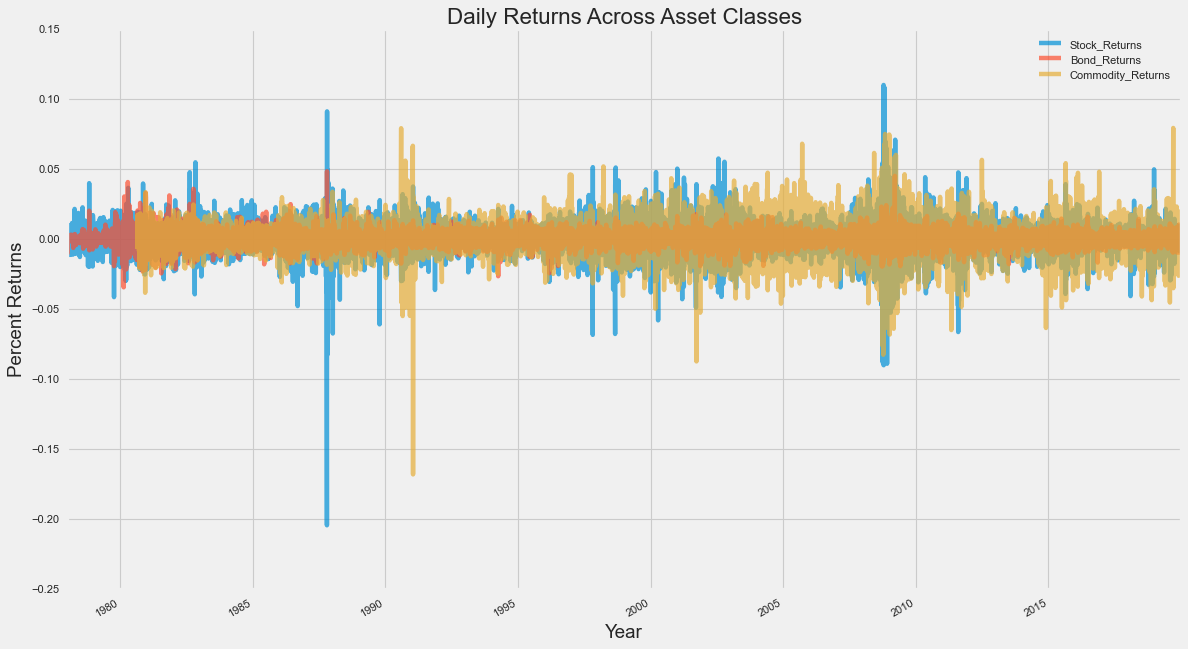

In [54]:
plt.style.use('fivethirtyeight')
response.plot(alpha=.7,figsize=(16,10)) 
plt.title('Daily Returns Across Asset Classes')
plt.ylabel('Percent Returns')
plt.xlabel('Year')

## Query features

In [55]:
#economic features

core_pce = fred.get_series('PCEPILFE',start_d,end_d).dropna()
core_pce=core_pce.pct_change().dropna()

nfp = fred.get_series('PAYEMS',start_d,end_d).dropna()
nfp = nfp.diff().dropna()

unemp = fred.get_series('UNRATE',start_d,end_d).dropna()

#excluding retail sales
#retail = fred.get_series('RSFSXMV',start_d,end_d).dropna()
#retail = retail.pct_change().dropna()

housing = fred.get_series('HOUST',start_d,end_d).dropna()

ip = fred.get_series('INDPRO',start_d,end_d).dropna()
ip = ip.pct_change().dropna()

ism = quandl.get("ISM/MAN_PMI",start_date=start_d, end_date=end_d)['PMI'].dropna() # Index to 50, above 50 = expanding comapred to prev month

umich_sent = fred.get_series('UMCSENT',start_d,end_d).dropna()

umich_inf = fred.get_series('MICH',start_d,end_d).dropna()

cpi = fred.get_series('CPILFESL',start_d,end_d).dropna()
cpi = cpi.pct_change().dropna()

economic_feat = {
    "Core_PCE":core_pce,
    "NFP": nfp,
    "UnEmp":unemp,
    "Hstarts":housing,
    "IP":ip,
    "ISM":ism,
    "Mich_Sent":umich_sent,
    "Mich_Inf":umich_inf,
    "CPI":cpi}

In [56]:
df_eco = pd.DataFrame(economic_feat).dropna()

In [57]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 1978-02-01 to 2019-12-01
Freq: MS
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Core_PCE   503 non-null    float64
 1   NFP        503 non-null    float64
 2   UnEmp      503 non-null    float64
 3   Hstarts    503 non-null    float64
 4   IP         503 non-null    float64
 5   ISM        503 non-null    float64
 6   Mich_Sent  503 non-null    float64
 7   Mich_Inf   503 non-null    float64
 8   CPI        503 non-null    float64
dtypes: float64(9)
memory usage: 39.3 KB


In [58]:
# Market Implied Features

bill3m = fred.get_series('TB3MS',start_d,end_d).dropna()

curve10y2y = fred.get_series('T10Y2Y',start_d,end_d).dropna()

y5 = fred.get_series('DGS5',start_d,end_d).dropna()
#y10 #calculated at top

In [59]:
#make sure index matches
(y5.index != y10.index).sum()

0

In [60]:
fwd5y5y = 2*y10 - y5

In [61]:
mkt_feat={
    "3M_Rate": bill3m,
    "10Y_2Y_Curve": curve10y2y,
    "5y5y_Forward": fwd5y5y
}

In [62]:
df_mkt = pd.DataFrame(mkt_feat)

In [63]:
df_mkt.resample('MS').mean()

,3M_Rate,10Y_2Y_Curve,5y5y_Forward
1978-01-01,6.44,0.470476,8.146190
1978-02-01,6.45,0.468333,8.234444
1978-03-01,6.29,0.460909,8.214091
1978-04-01,6.29,0.410500,8.325500
1978-05-01,6.41,0.339524,8.515714
...,...,...,...
2019-08-01,1.95,0.055000,1.765909
2019-09-01,1.89,0.051500,1.834000
2019-10-01,1.65,0.155455,1.888636
2019-11-01,1.54,0.199474,1.984737


In [64]:
#spot check
print(bill3m.loc['2019-10-1'])
print(curve10y2y.loc['2019-10'].mean())
print(fwd5y5y.loc['2019-10'].mean())



1.65
0.15545454545454543
1.888636363636364


In [65]:
#looks good
df_mkt=df_mkt.resample('MS').mean()

In [66]:
df_feat = df_mkt.join(df_eco)

In [67]:
df_feat

,3M_Rate,10Y_2Y_Curve,5y5y_Forward,Core_PCE,NFP,UnEmp,Hstarts,IP,ISM,Mich_Sent,Mich_Inf,CPI
1978-01-01,6.44,0.470476,8.146190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-02-01,6.45,0.468333,8.234444,0.003835,354.0,6.3,1738.0,0.004951,55.9,84.3,6.4,0.004754
1978-03-01,6.29,0.460909,8.214091,0.005407,512.0,6.3,2032.0,0.019062,55.0,78.8,6.3,0.006309
1978-04-01,6.29,0.410500,8.325500,0.006489,702.0,6.1,2197.0,0.020717,57.7,81.6,6.7,0.007837
1978-05-01,6.41,0.339524,8.515714,0.005866,347.0,6.0,2075.0,0.003709,60.2,82.9,6.9,0.006221
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1.95,0.055000,1.765909,0.001419,207.0,3.7,1377.0,0.007050,48.8,89.8,2.7,0.002250
2019-09-01,1.89,0.051500,1.834000,0.000766,208.0,3.5,1274.0,-0.003476,48.2,93.2,2.8,0.001900
2019-10-01,1.65,0.155455,1.888636,0.001300,185.0,3.6,1340.0,-0.004070,48.5,95.5,2.5,0.001152
2019-11-01,1.54,0.199474,1.984737,0.000471,261.0,3.5,1371.0,0.009280,48.1,96.8,2.5,0.001940


In [69]:
df_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
3M_Rate,504.0,4.442619,3.621002,0.010000,1.170000,4.555000,6.442500,16.300000
10Y_2Y_Curve,504.0,0.931684,0.929142,-2.135714,0.223750,0.859012,1.618182,2.834211
5y5y_Forward,504.0,6.603806,3.067481,1.765909,4.504762,5.874318,8.539529,14.889524
Core_PCE,503.0,0.002394,0.001888,-0.005599,0.001192,0.001912,0.002991,0.009978
NFP,503.0,134.003976,207.156041,-800.000000,50.500000,175.000000,264.500000,1118.000000
UnEmp,503.0,6.186879,1.648090,3.500000,5.000000,5.800000,7.200000,10.800000
Hstarts,503.0,1373.918489,397.552506,478.000000,1112.000000,1416.000000,1649.500000,2273.000000
IP,503.0,0.001617,0.006687,-0.043368,-0.001991,0.002060,0.005600,0.020717
ISM,503.0,52.045924,5.806009,29.400000,49.300000,52.500000,56.050000,69.900000
Mich_Sent,503.0,86.316501,12.649808,51.700000,76.500000,90.000000,95.100000,112.000000


## DONE
 
df_feat contains all the features on a monthly basis

response contains the daily % returns of stocks and bonds

In [ ]:
df_feat.to_csv("raw_features.csv")
response.to_csv("raw_response.csv")

In [86]:
c = response[['Stock_Returns','Commodity_Returns']].resample('M').std().join(response[['Stock_Returns','Commodity_Returns']].resample('M').mean(),rsuffix='_mean',lsuffix='_std').corr()
c = response.resample('M').std().join(response.resample('M').mean(),rsuffix='_mean',lsuffix='_std').corr()


In [87]:
import seaborn as sns

Text(0.5, 1.0, 'Returns vs. Std. Correlation')

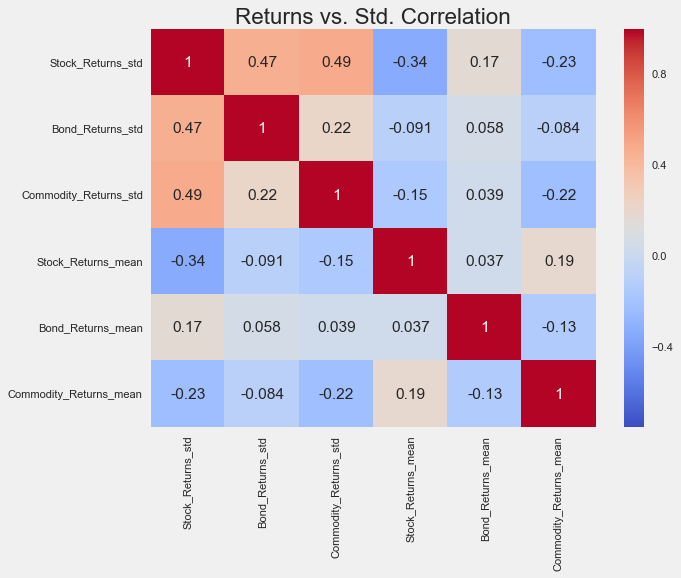

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(c,vmin=-.75,annot=True,cmap='coolwarm')
plt.title('Returns vs. Std. Correlation')